# Problème n°2: PointNet

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os

In [13]:
#############################################################
#pour la visualisation des images ###########################
#############################################################

def voir_mat(data2, fig, min_scale=-10,max_scale=70):

    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(data2, interpolation='nearest', cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def voir_tens(image, fig, min_scale=-1,max_scale=1):
    im=image[0,0,:,:].numpy()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(im, interpolation='nearest',  cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def conc(image1,image2,dim=3):
    return torch.cat((image1,image2), dim) #, out=None)

def multi_conc(L,dim=1,ecart=5, min_scale=0.5):
    image1=L[0]
    for i in range(1, len(L)):
        if dim==1:
            sep=  min_scale + 0*image1[:,0:ecart]
        elif dim==0:
            sep=  min_scale + 0*image1[0:ecart,:]
        image1=conc(image1,sep,dim)
        image2=L[i]
        image1=conc(image1,image2,dim=dim)
    return image1

def images_from_tenseur(tens, k=0):
    len_batch=tens.shape[0]
    L=[]
    for i in range(len_batch):
        L.append(tens[i,k,:,:])
    return L

def voir_batch2D(tens, nx, fig,k=0, min_scale=-10,max_scale=1):
    s = 0.5*(min_scale + max_scale)
    L=images_from_tenseur(tens,k)
    image1=multi_conc(L[0:nx],dim=1, min_scale=s)
    for i in range(1,int(len(L)/nx)):
        image2=multi_conc(L[i*nx:(i+1)*nx],dim=1, min_scale=s)
        image1=multi_conc([image1,image2],dim=0, min_scale=s)
    voir_mat(image1, fig, min_scale,max_scale)


#############################################################
#pour la génération des images    ###########################
#############################################################

def simu_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]=  np.random.uniform(0,0.4)   #0.1
    image=image + rec
    return image

def simu_noisy_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]= np.random.uniform(0,0.4)  #0.1
    noise=torch.randn(channels,size,size2)
    noise=noise*(noise>0).float()
    rec=noise*rec
    image=image + rec
    return image

def simu_disc(image, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius, size-radius) , randint(radius, size-radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    return image

def simu_disc_with_cond(image, f, radius=15, fields=0, f2 = lambda a,x  : ((np.sin(3.1 * a/x**2)))*(a < x**2) ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius-5, size-radius+2) , randint(radius-2, size-radius+5) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[0,:,:] = image[0,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    if (radius >= 10) and (radius <= 14):
        npdon = f2( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
        image[1,:,:] = image[1,:,:] + torch.from_numpy(npdon).float()**2
    return image


def simu_square(image, f, diag=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2 = image.size()
    center=np.array([randint(diag, size-diag) , randint(diag, size-diag) ])

    npsquare = f(  np.abs(np.arange(0,64)*np.ones([size,size]) - center[0]) + \
                   np.abs(np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1]), diag)
#    npsquare = np.abs(np.arange(0,64)*np.ones([size,size]) - center[0])
    npsquare = np.random.uniform(0.6,1.) * npsquare  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npsquare).float()   #matrice des distances < rayon
    return image


def plot_pairs(image, f = lambda x : x**2):
    horizontal = (torch.randint(0,2,(1,)) > 0.5).item()
#    print(horizontal)
    dist = torch.randint(1,32, (1,)).item()
    if horizontal :
        ordo = torch.randint(0, 64, (1,)).item()
        absi = torch.randint(0, 64 - dist, (1,)).item()
        image[1, ordo, absi:(absi + dist + 1)] \
            += 0.1 + torch.mean(f(image[0, ordo, absi:(absi + dist + 1)]))
    else :
        ordo = torch.randint(0, 64 - dist, (1,)).item()
        absi = torch.randint(0, 64, (1,)).item()
        image[1, ordo:ordo+dist+1, absi] \
            += 0.1 + torch.mean(f(image[0, ordo:ordo+dist+1, absi]))
    return image



def make_image(rec, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_image_with_cond(rec, noisy_rec ,disc,square=0., pola=[0]):
    image = torch.zeros([2, 64, 64])
    image = generate_noise_with_cond(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_batch(batch_size, rec, noisy_rec ,disc, square=0., pola=[0] ):
    out = make_image(rec, noisy_rec ,disc , square, pola ).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image(rec, noisy_rec ,disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def generate_noise(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    if pola[0]==1:      #add a pseudo pola field
        image_pola = generate_pola(image,pola)
        image=torch.cat([image,image_pola],dim=0)
    return image



def gen_pointnet(n, N=700, M=800):
  x = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  y = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0005)
  x[y>0] = y[y>0]
  y = (y > 0).long()

  # points
  xis = []
  yis = []
  for i in range(x.shape[0]):
    xi, yi = get_random_xy_triplets(x[i].squeeze(0), y[i].squeeze(0), N, M)
    xis.append(xi.unsqueeze(0))
    yis.append(yi.unsqueeze(0))
  ux = torch.transpose(torch.cat(xis, dim=0),1,2)
  # ux[:,2] += torch.rand(1).cuda()
  uy = torch.transpose(torch.cat(yis, dim=0),1,2)

  # Normalisation / réduction de y:
  ux[:,:2,:] /= 64
  uy = uy[:,2,:]
  xy = torch.cat((ux[:,:2,:], uy.unsqueeze(1)), dim=1)

  return  x, y, ux, uy, xy


def gen_pointcloud(n, N=700, M=800):
  x = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  y = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0005)
  x[y>0] = y[y>0]
  y = (y > 0).long()

  # points
  xis = []
  yis = []
  for i in range(x.shape[0]):
    xi, yi = get_random_xy_triplets(x[i].squeeze(0), y[i].squeeze(0), N, M)
    xis.append(xi.unsqueeze(0))
    yis.append(yi.unsqueeze(0))
  ux = torch.transpose(torch.cat(xis, dim=0),1,2)
  # ux[:,2] += torch.rand(1).cuda()
  uy = torch.transpose(torch.cat(yis, dim=0),1,2)

  # Normalisation / réduction de y:
  ux[:,:2,:] /= 64
  uy = uy[:,2,:]
  xy = torch.cat((ux[:,:2,:], uy.unsqueeze(1)), dim=1)

  return  ux, uy, xy

#####################################################################################################
#################################### Passage PointCloud #############################################

def get_random_triplets(tensor, N, M): # N : max non zero elements M: total elements
    # Find indices of non-zero elements
    non_zero_indices = torch.nonzero(tensor, as_tuple=True)
    row_indices, col_indices = non_zero_indices

    # Extract corresponding non-zero values
    values = tensor[non_zero_indices]

    # Create triplets for non-zero elements
    non_zero_triplets = torch.stack((row_indices, col_indices, values), dim=1)

    # Shuffle the non-zero triplets
    shuffle_indices = torch.randperm(non_zero_triplets.size(0))
    shuffled_non_zero_triplets = non_zero_triplets[shuffle_indices]

    # Determine the number of non-zero triplets
    K = shuffled_non_zero_triplets.size(0)

    if K > N :
      shuffled_non_zero_triplets = shuffled_non_zero_triplets[:N]
    # print(shuffled_non_zero_triplets.size(0))
    # Find zero values to potentially add
    zero_indices = torch.nonzero(tensor == 0, as_tuple=True)
    zero_row_indices, zero_col_indices = zero_indices

    # Create zero triplets
    zero_triplets = torch.stack((zero_row_indices, zero_col_indices, 0 * zero_col_indices), dim=1)

    # Shuffle zero triplets
    shuffle_indices_zero = torch.randperm(zero_triplets.size(0))
    shuffled_zero_triplets = zero_triplets[shuffle_indices_zero]

    # Subsample N-K zero triplets
    # L = shuffled_zero_triplets.size(0)
    subsampled_zero_triplets = shuffled_zero_triplets[:(M - N)]
    # print('nnn', subsampled_zero_triplets.size(0))
    # Combine non-zero and zero triplets
    final_triplets = torch.cat((shuffled_non_zero_triplets, subsampled_zero_triplets), dim=0)


    return final_triplets.unsqueeze(dim=0)


def get_random_xy_triplets(x, y, N, M): # N : max non zero elements M: total elements
    # Find indices of non-zero elements
    non_zero_indices = torch.nonzero(x, as_tuple=True)
    row_indices, col_indices = non_zero_indices

    # Extract corresponding non-zero values
    valuesx = x[non_zero_indices]
    valuesy = y[non_zero_indices]

    # Create triplets for non-zero elements
    non_zero_triplets_x = torch.stack((row_indices, col_indices, valuesx), dim=1)
    non_zero_triplets_y = torch.stack((row_indices, col_indices, valuesy), dim=1)

    # Shuffle the non-zero triplets
    shuffle_indices = torch.randperm(non_zero_triplets_x.size(0))
    shuffled_non_zero_triplets_x = non_zero_triplets_x[shuffle_indices]
    shuffled_non_zero_triplets_y = non_zero_triplets_y[shuffle_indices]

    # Determine the number of non-zero triplets
    K = shuffled_non_zero_triplets_x.size(0)

    if K > N :
      shuffled_non_zero_triplets_x = shuffled_non_zero_triplets_x[:N]
      shuffled_non_zero_triplets_y = shuffled_non_zero_triplets_y[:N]
    K = min(K,N)

    # Find zero values to potentially add
    zero_indices = torch.nonzero(x == 0, as_tuple=True)
    zero_row_indices, zero_col_indices = zero_indices

    # Create zero triplets
    zero_triplets_x = torch.stack((zero_row_indices, zero_col_indices,
                                   0 * zero_col_indices), dim=1)
    zero_triplets_y = torch.stack((zero_row_indices, zero_col_indices, y[zero_indices]), dim=1)

    # Shuffle zero triplets
    shuffle_indices_zero = torch.randperm(zero_triplets_x.size(0))
    shuffled_zero_triplets_x = zero_triplets_x[shuffle_indices_zero]
    shuffled_zero_triplets_y = zero_triplets_y[shuffle_indices_zero]

    # Subsample N-K zero triplets
    # L = shuffled_zero_triplets.size(0)
    subsampled_zero_triplets_x = shuffled_zero_triplets_x[:(M - K)]
    subsampled_zero_triplets_y = shuffled_zero_triplets_y[:(M - K)]
    # print('nnn', subsampled_zero_triplets.size(0))
    # Combine non-zero and zero triplets
    final_triplets_x = torch.cat((shuffled_non_zero_triplets_x, subsampled_zero_triplets_x), dim=0)
    final_triplets_y = torch.cat((shuffled_non_zero_triplets_y, subsampled_zero_triplets_y), dim=0)

    return final_triplets_x, final_triplets_y
#####################################################################################################
###################################### Tracé nuage de points ########################################

def plot_triplets(triplets, elev=90, azim=0,
                  title='Nuage d entree',cbar_label='z'):
    # Convert triplets to a transposed list for easier plotting
    triplets_transposed = list(zip(*triplets))

    # Extracting the row indices, column indices, and values
    row_indices = triplets_transposed[0]
    col_indices = triplets_transposed[1]
    values = triplets_transposed[2]

    # Creating the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the points
    scatter = ax.scatter(row_indices, col_indices, values, c=values, cmap='viridis', marker='o')

    ax.view_init(elev=elev, azim=azim)
    # Adding labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(cbar_label)
    plt.title(title)

    # Adding a color bar
    cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
    cbar.set_label(cbar_label)

    plt.show()

# Assuming 'triplets' is your list of triplets from the previous function
# You would call the function like this:
# plot_triplets(triplets)


def plot_triplets_orthogonal_projection(triplets):
    # Convert triplets to a transposed list for easier plotting
    triplets_transposed = list(zip(*triplets))

    # Extracting the row indices and column indices
    row_indices = triplets_transposed[0]
    col_indices = triplets_transposed[1]
    # values = triplets_transposed[2]  # Unused for orthogonal XY projection

    # Creating the plot
    plt.figure(figsize=(8, 6))

    # Plotting the points on XY plane
    plt.scatter(row_indices, col_indices, c='blue', marker='o')

    # Adding labels and title
    plt.xlabel('Row Index')
    plt.ylabel('Column Index')
    plt.title('Orthogonal Projection onto XY Plane')
    plt.grid(True)

    plt.show()

# Assuming 'triplets' is your list of triplets from the previous function
# You would call the function like this:
# plot_triplets_orthogonal_projection(triplets)



In [ ]:
# Si on veut sauvegarder le notebook sur sur google drive
# from google.colab import drive
# import os
# drive.mount('/content/drive')

In [4]:
! git clone https://github.com/nanopiero/PREAC.git

Cloning into 'PREAC'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 127 (delta 66), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (127/127), 7.26 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [5]:
! pip install einops

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rzectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


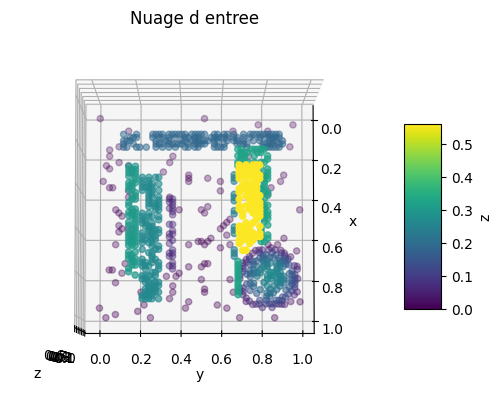

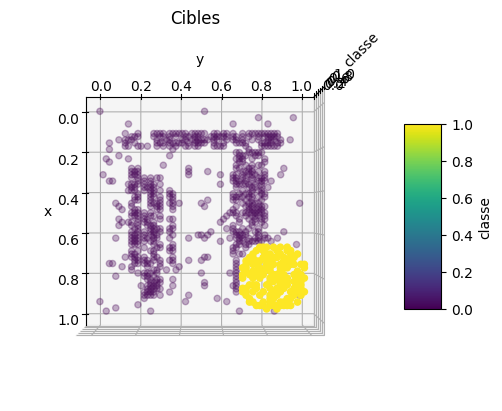

1


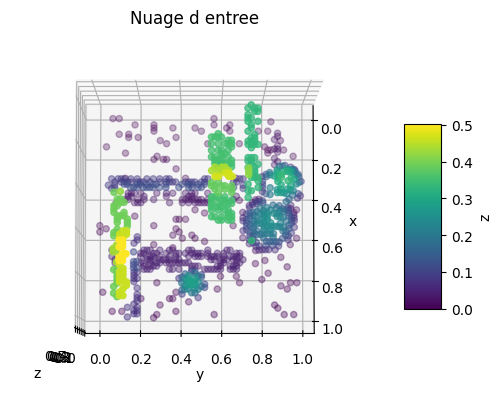

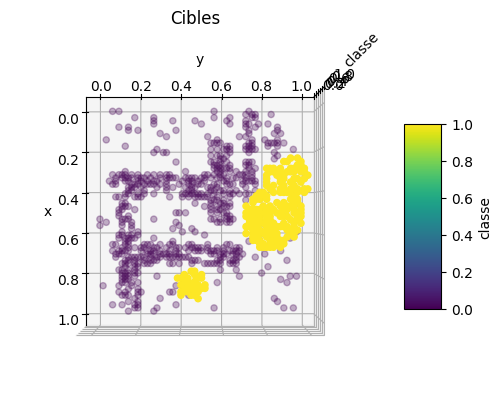

2


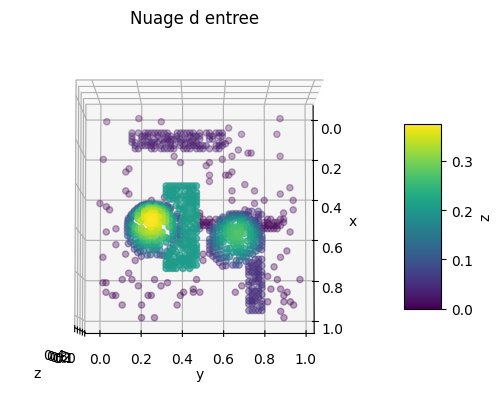

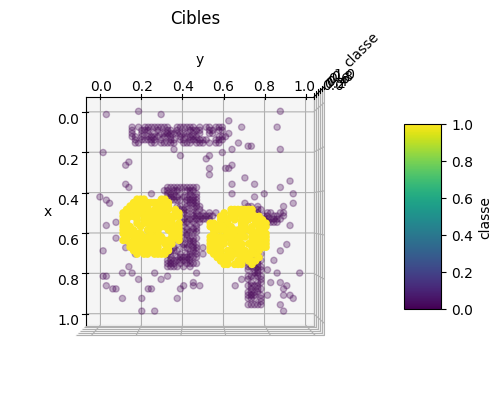

3


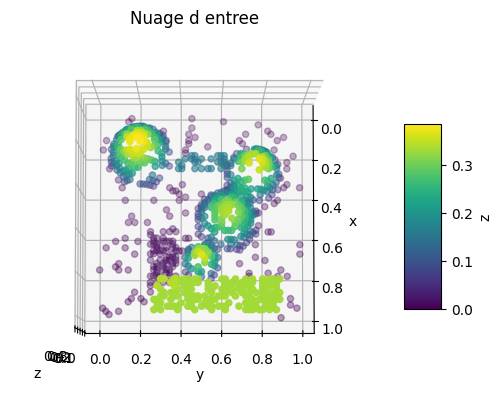

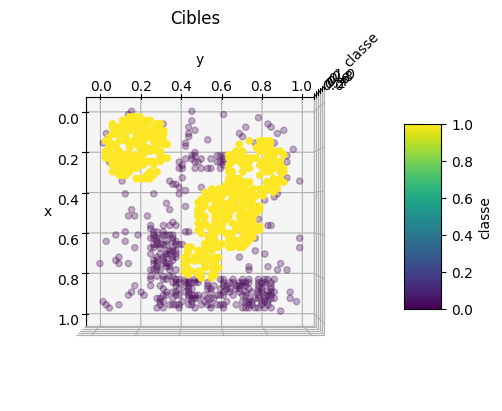

4


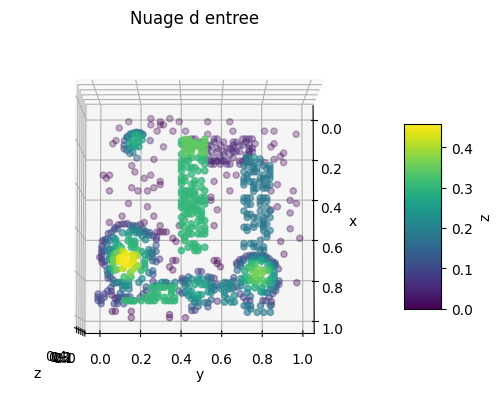

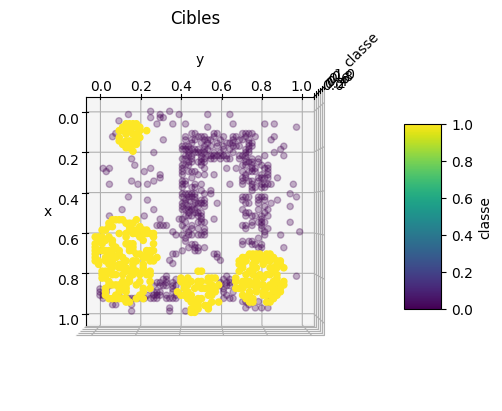

5


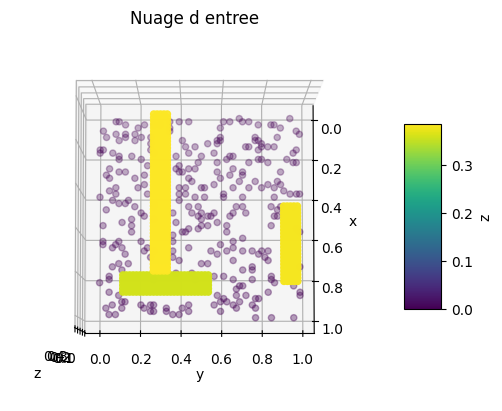

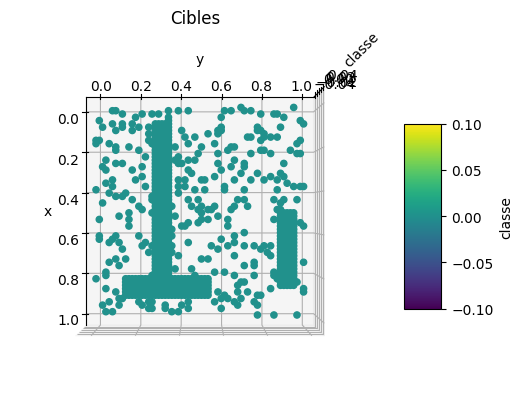

In [105]:
# from utils.utils_probleme2 import gen_pointcloud

batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

## Partie II : le modèle PointNet

In [39]:
'''
Contains classed comprising Point Net Architecture. Usage for each class can
be found in main() at the bottom.

TO use: Import Classification and Segmentation classes into desired script



NOTE:
This architecture does not cover Part Segmentation. Per the Point Net paper
that is a different architecture and is not implemented here.
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


# ============================================================================
# T-net (Spatial Transformer Network)
class Tnet(nn.Module):
    ''' T-Net learns a Transformation matrix with a specified dimension '''
    def __init__(self, dim, num_points=2500):
        super(Tnet, self).__init__()

        # dimensions for transform matrix
        self.dim = dim

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)


    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)

        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x


# ============================================================================
# Point Net Backbone (main Architecture)
class PointNetBackbone(nn.Module):
    '''
    This is the main portion of Point Net before the classification and segmentation heads.
    The main function of this network is to obtain the local and global point features,
    which can then be passed to each of the heads to perform either classification or
    segmentation. The forward pass through the backbone includes both T-nets and their
    transformations, the shared MLPs, and the max pool layer to obtain the global features.

    The forward function either returns the global or combined (local and global features)
    along with the critical point index locations and the feature transformation matrix. The
    feature transformation matrix is used for a regularization term that will help it become
    orthogonal. (i.e. a rigid body transformation is an orthogonal transform and we would like
    to maintain orthogonality in high dimensional space). "An orthogonal transformations preserves
    the lengths of vectors and angles between them"
    '''
    def __init__(self, num_points=2500, num_global_feats=1024, local_feat=True):
        ''' Initializers:
                num_points - number of points in point cloud
                num_global_feats - number of Global Features for the main
                                   Max Pooling layer
                local_feat - if True, forward() returns the concatenation
                             of the local and global features
            '''
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)

        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)


    def forward(self, x):

        # get batch size
        bs = x.shape[0]

        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))

        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features,
                                  global_features.unsqueeze(-1).repeat(1, 1, self.num_points)),
                                  dim=1)

            return features, critical_indexes, A_feat

        else:
            return global_features, critical_indexes, A_feat


# ============================================================================
# Classification Head
class PointNetClassHead(nn.Module):
    '''' Classification Head '''
    def __init__(self, num_points=2500, num_global_feats=1024, k=2):
        super(PointNetClassHead, self).__init__()

        # get the backbone (only need global features for classification)
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=False)

        # MLP for classification
        self.linear1 = nn.Linear(num_global_feats, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, k)

        # batchnorm for the first 2 linear layers
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

        # The paper states that batch norm was only added to the layer
        # before the classication layer, but another version adds dropout
        # to the first 2 layers
        self.dropout = nn.Dropout(p=0.3)


    def forward(self, x):
        # get global features
        x, crit_idxs, A_feat = self.backbone(x)

        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        x = self.dropout(x)
        x = self.linear3(x)

        # return logits
        return x, crit_idxs, A_feat


# ============================================================================
# Segmentation Head
class PointNetSegHead(nn.Module):
    ''' Segmentation Head '''
    def __init__(self, num_points=2500, num_global_feats=1024, m=2):
        super(PointNetSegHead, self).__init__()

        self.num_points = num_points
        self.m = m

        # get the backbone
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

        # shared MLP
        num_features = num_global_feats + 64 # local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, m, kernel_size=1)

        # batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):

        # get combined features
        x, crit_idxs, A_feat = self.backbone(x)

        # pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1)

        return x, crit_idxs, A_feat


# special loss for segmentation Focal Loss + Dice Loss
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, size_average=True):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average

        # get Balanced Cross Entropy Loss
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)


    def forward(self, predictions, targets, pred_choice=None):

        # get Balanced Cross Entropy Loss
        ce_loss = self.cross_entropy_loss(predictions.transpose(2, 1), targets)

        # reformat predictions (b, n, c) -> (b*n, c)
        predictions = predictions.contiguous() \
                                 .view(-1, predictions.size(2))
        # get predicted class probabilities for the true class
        pn = F.softmax(predictions)
        pn = pn.gather(1, targets.view(-1, 1)).view(-1)

        # compute loss (negative sign is included in ce_loss)
        loss = ((1 - pn)**self.gamma * ce_loss)

        if self.size_average:
          loss = loss.mean()
        else:
          loss = loss.sum()

        # add dice coefficient if necessary
        if self.dice:
          return loss + self.dice_loss(targets, pred_choice, eps=1)
        else:
          return loss


    @staticmethod
    def dice_loss(predictions, targets, eps=1):
        ''' Compute Dice loss, directly compare predictions with truth '''

        targets = targets.reshape(-1)
        predictions = predictions.reshape(-1)

        cats = torch.unique(targets)

        top = 0
        bot = 0
        for c in cats:
            locs = targets == c

            # get truth and predictions for each class
            y_tru = targets[locs]
            y_hat = predictions[locs]

            top += torch.sum(y_hat == y_tru)
            bot += len(y_tru) + len(y_hat)


        return 1 - 2*((top + eps)/(bot + eps))



Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [106]:
# from utils.utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

**Q2** L'architecture de pointnet est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés ici:

https://huggingface.co/nanopiero/pointnet_igloos/blob/main/pointnet_500_ep.pth

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [70]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

In [ ]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
    ...

In [104]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
